In [7]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

### Ex 1, 2 : Hoeffding Inequality

In [17]:
trials = 100000
v1_list = []
vmin_list = []
vrand_list = []

for _ in range(trials):
    coin = np.random.rand(10, 1000)       # 10 tosses, 1000 coins
    coin = (coin > 0.5).astype(float)     # 1=H, 0=T
    coin = coin.mean(axis=0)              # get fraction of H for each coin
    v1_list.append(coin[0])
    vmin_list.append(coin.min())
    vrand_list.append(coin[np.random.randint(0, 1000)])

print(np.mean(vmin_list), np.mean(v1_list), np.mean(vrand_list))

0.037679 0.499939 0.500887


In [8]:
df = pd.DataFrame({'v1':v1_list, 'vmin':vmin_list, 'vrand':vrand_list})

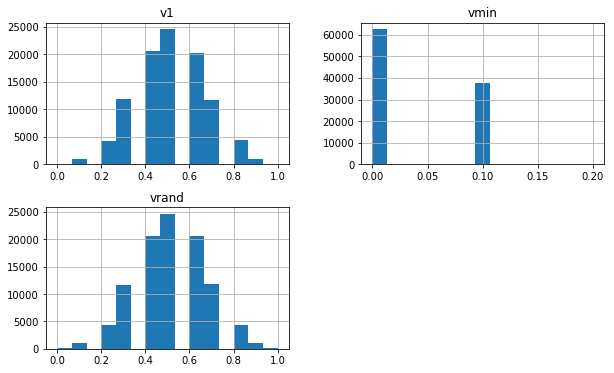

In [14]:
df.hist(bins=15, figsize=(10, 6))
plt.show()

### Ex 5-7: Linear Regression


In [52]:
def make_line(p1, p2):
    '''take 2 points and return w
    inwhich w*[1, x1, x2] = 0'''
    dx, dy = p2-p1
    m = dy/dx
    b = p1[1] - m*p1[0]
    return np.array([b, m, -1.])

def make_Xn(n_points):
    '''create 2-d inputs Xn plus bias'''
    X = np.random.uniform(-1, 1, size=(n_points, 2))
    return np.c_[np.ones(n_points), X]

def make_yn(f, X):
    '''take target function f and input Xn
    to generate output yn'''
    return np.where(np.dot(X, f) > 0, 1, -1)

def mse(y_true, y_pred):
    err = y_true - y_pred
    return np.dot(err, err) / len(y_true)

In [93]:
class PLA:
    '''Perceptron Learning Algorithm'''
    
    def __init__(self, w, max_iters=1000):
        self._w = w
        self._num_iters = 0
        self._max_iters = max_iters
        
    def fit(self, X, y):
        for i in range(self._max_iters):
            self._num_iters += 1
            y_pred = self.predict(X)
            err = (y_pred != y)
            if err.sum() > 0:
                idx = np.random.randint(0, err.sum())
                self._w += y[err][idx]*X[err][idx]
            elif self._num_iters == self._max_iters:
                self._num_iters = None
                break
            else:
                break
        return self
    
    def predict(self, X):
        y = np.dot(X, self._w)
        return np.sign(y)
    

[-1, 1, -1, 1]

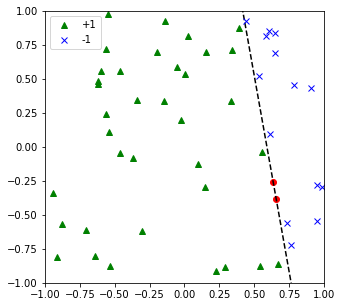

In [49]:
# test make_line(), make_yn(), make_Xn()

plt.figure(figsize=(5, 5))
p1, p2 = np.random.uniform(-1, 1, size=(2, 2))
w = make_line(p1, p2)

plt.plot([p1[0], p2[0]], [p1[1], p2[1]], 'ro')

xs = np.linspace(-1, 1)
ys = np.dot(np.c_[np.ones(len(xs)), xs], w[:2])
plt.plot(xs, ys, 'k--')

X = make_Xn(50)
y = make_yn(w, X)
y_pos = (y == 1)
y_neg = (y == -1)
plt.plot(X[y_pos, 1], X[y_pos, 2], 'g^', label='+1')
plt.plot(X[y_neg, 1], X[y_neg, 2], 'bx', label='-1')
plt.legend(loc='best')
plt.axis([-1,1,-1,1])

In [67]:
X_pinv = np.linalg.pinv(X)
X_dot = np.dot(np.linalg.inv(np.dot(X.T, X)), X.T)

np.allclose(X_pinv, X_dot)

True

average E_in: 0.036274
average E_out: 0.037131


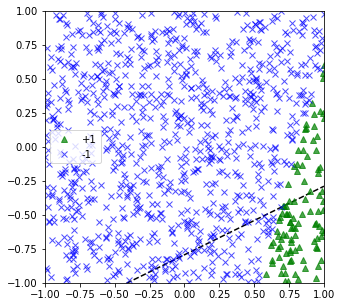

In [111]:
# ex 5
n_out = 1000
trials = 1000
E_in = []
E_out = []
pla_num_iters = []

for _ in range(trials):
    
    # generate random target function
    N = 1000
    p1, p2 = np.random.uniform(-1, 1, size=(2, 2))
    f = make_line(p1, p2)

    X = make_Xn(N)
    y = make_yn(f, X)
    
    # Linear regression using pseudo-inverse of X
    g = np.dot(np.linalg.pinv(X), y)
    y_hat = make_yn(g, X)
    
    # use perceptron to train with inital weight = g
    '''
    perceptron = PLA(g)
    perceptron = perceptron.fit(X, y)
    if perceptron._num_iters is not None:
        pla_num_iters.append(perceptron._num_iters)
    '''
    # get E_in(g, f)
    E_in.append((y != y_hat).mean())
    
    # generate random X_out 1000 points
    X_out = make_Xn(1000)
    y_out = make_yn(f, X_out)
    y_out_hat = make_yn(g, X_out)
    # compute E_out(g, f)
    E_out.append((y_out != y_out_hat).mean())

print('average E_in:', np.mean(E_in))
print('average E_out:', np.mean(E_out))
#print('average PLA training iters:', np.mean(pla_num_iters))
# plot decision boundary
plt.figure(figsize=(5, 5))
xs = np.linspace(-1, 1)
ys = np.dot(np.c_[np.ones(len(xs)), xs], g[:2])
plt.plot(xs, ys, 'k--')

y_pos = (y == 1)
y_neg = (y == -1)
plt.plot(X[y_pos, 1], X[y_pos, 2], 'g^', label='+1', alpha=.7)
plt.plot(X[y_neg, 1], X[y_neg, 2], 'bx', label='-1', alpha=.7)
plt.legend(loc='best')
plt.axis([-1,1,-1,1])
plt.show()

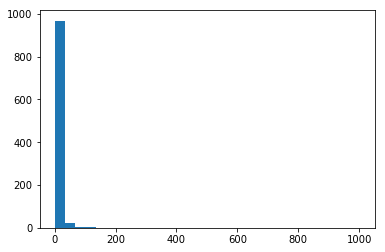

In [107]:
plt.hist(pla_num_iters, bins=30)
plt.show()

### Ex.8-10: Nonlinear Transformation

In [132]:
def f(X):
    return np.sign(np.dot(X**2, [-.6, 1, 1]))

def make_y_noise(y, p):
    result = np.where(np.random.rand(*y.shape) < p, -1, 1)
    return y * result

def transform_X(X):
    x0, x1, x2 = X.T
    return np.c_[x0, x1, x2, x1*x2, x1**2, x2**2]

In [143]:
LinReg_Ein = []
X_tran_Eout = []
w_trans_avg = np.zeros(6)
trials = 1000

for _ in range(trials):
    N = 1000
    X = make_Xn(N)
    #y = f(X)
    y_noise = make_y_noise(f(X), .1)
    
    # lin-reg model
    w = np.dot(np.linalg.pinv(X), y_noise)
    
    y_hat = np.sign(np.dot(X, w))
    
    LinReg_Ein.append((y_hat != y_noise).mean())
    
    X_tran = transform_X(X)
    w_tran = np.dot(np.linalg.pinv(X_tran), y_noise)
    
    w_trans_avg += w_tran
    # new random point for E_out
    X_out = make_Xn(1000)
    y_out_noise = make_y_noise(f(X_out), p=.1)
    X_out = transform_X(X_out)
    
    y_out_pred = np.sign(np.dot(X_out, w_tran))
    
    X_tran_Eout.append((y_out_pred != y_out_noise).mean())
    
print('E_in (X-space):', np.mean(LinReg_Ein), ' +/-', np.std(LinReg_Ein))
print('E_out (X_tran):', np.mean(X_tran_Eout), ' +/-', np.std(X_tran_Eout))
print('w_tran:', np.round(w_trans_avg/trials, 2))

E_in (X-space): 0.503552  +/- 0.0430927522444
E_out (X_tran): 0.126604  +/- 0.0130867560534
w_tran: [-0.99 -0.    0.    0.    1.56  1.56]


In [139]:
w_tran.round(2)

array([-0.95, -0.02,  0.02,  0.07,  1.43,  1.55])

In [141]:
w_trans_avg

array([ -9.91199234e+02,   1.84551696e-02,  -7.05556606e-01,
         4.80690698e-01,   1.55689482e+03,   1.55464104e+03])